In [122]:
# import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import BigramCollocationFinder,TrigramCollocationFinder
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
import csv
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia
nltk.download('maxent_ne_chunker')
nltk.download('words')
pd.set_option('max_rows',None)
pd.set_option('max_columns', None)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Ish\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Ish\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [123]:
# load resources
steamtop = pickle.load(open('steam_backup_top_350.p','rb'))
steammid = pickle.load(open('steam_back_up_middle_350.p','rb'))
steambottom = pickle.load(open('steam_back_up_bottom_350.p','rb'))
steamfull = pickle.load(open('steam_data_plan_b_clean.p', 'rb'))
# steam reviews from pickled lists
steamtop['reviews'] = pickle.load(open('steam_top_380.p','rb'))
steammid['reviews'] = pickle.load(open('steam_mid_380s_reviews.p','rb'))
steambottom['reviews'] = pickle.load(open('steam_bottom_380.p','rb'))

In [124]:
# create new dataframes for NLP.
steam_t = steamtop[['steam_appid', 'name', 'metacritic', 'reviews']].reset_index()

steam_m = steammid[['steam_appid', 'name', 'metacritic', 'reviews']].reset_index()

steam_b = steambottom[['steam_appid', 'name', 'metacritic', 'reviews']].reset_index()

# create a list for convenient iteration through the rows
steam_team = [steam_t, steam_m, steam_b]


In [127]:
# process reviews for analysis.
# Create a column to keep track of the number of reviews for each game.
for df in steam_team:
    review_counts = []
    for x in range(len((df['reviews']))):
        try: 
            review_counts.append(len(df['reviews'][x]))
        except:
            review_counts.append(np.NaN)
    df['review_counts'] = review_counts

for df in steam_team:
    df.sort_values(by ='review_counts', ascending = False)

# get the average wordcount for reviews by game and a list of those numbers.

def review_length_list(review_list):
    review_lengths = []
    for l in review_list:
        try:
            review_lengths.append(len(l.split(' ')))
        except:
            review_lengths.append(0)
        return {f"{len(review_list)} review(s)":review_lengths}

# create a new column of the average sentiment scores for each game
lengths = []
for x in steam_team:
    for r in range(len(x['reviews'])):
        try:
            lengths.append(review_length_list(y))
        except:
            lengths.append(np.NaN)


In [128]:
# start processing reviews.
# convert reviews to usable format as a list of strings, rather than a list of lists of strings.

for df in steam_team:
    df_review_document = []
    for x in range(len((df['reviews']))):
        df_review_document.append(','.join(df['reviews'][x]))
    df['review_update'] = df_review_document



TypeError: can only join an iterable

In [130]:
# define functions for cleaning and preparing text data for analysis.
# preliminary cleaning
def clean_up(string):
    # sort through input and remove any patterns that look like urls.
    import regex as re
    # use regex to identify and drop URL strings.
    url_to_drop = re.findall('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', string)
    try:
        string = string.replace(url_to_drop[0], " ")
    except:
        string=string
    # use regex to identify non-functional special characters
    chars_to_drop = re.findall('\W',string)
    for x in range(len(chars_to_drop)):
        string = string.replace(chars_to_drop[x],' ')
    # use regex to identify numerical values to drop.
    nums_to_drop = re.findall('\S?[0-9]', string)
    for n in range(len(nums_to_drop)):
        string = string.replace(nums_to_drop[n], ' ')
    # convert all remaining items to lower case
    return string.lower()

# tokenizing the cleaned text data
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

def tokenize(string):
    s_tokenized = nltk.word_tokenize(string)
    return s_tokenized

# produce stemmed and lemmatized results of the text input
def get_pos(tokenlist):
    pos_list = []
    for x in tokenlist:
        tag = nltk.pos_tag([x])[0][1][0].upper() # gets first letter of POS categorization
        tag_dict = {"J": wordnet.ADJ, 
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN) # get returns second argument if first key does not exist 

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
def stem_and_lemmatize(l):
    p_stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    l_stemmed = [p_stemmer.stem(l[x]) for x in range(len(l))]
    l_lemmatized = []
    for x in l:
        try:    
            l_lemmatized.append(lemmatizer.lemmatize(x, pos = (get_pos(x))))
        except:
            pass     
    return l_lemmatized

# remove stopwords from text sample.
from nltk.corpus import stopwords
nltk.download('stopwords')
def remove_stopwords(l):
    l_stopped = [word for word in l if not word in stopwords.words('english')]
    l_stopped = [word for word in l_stopped if word not in ['game','play','s', 'wa', 'good', 'like', 'lol','rofl', 'ha'] ]
    return l_stopped

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
# define a function to be clean text bodies for each row and output a list of lemmatized words.
def nlp_processing(x):
    cleaned = clean_up(x)
    tokenized = tokenize(cleaned)
    stemmd_n_lemmd = stem_and_lemmatize(tokenized)
    processed_ = remove_stopwords(stemmd_n_lemmd)      
    return processed_


In [132]:
for df in steam_team:
    df['clean_reviews'] = df['review_update'].apply(lambda x: nlp_processing(x))

In [ ]:
# Determine average sentiment of reviews for each game using textblob
from textblob import TextBlob
# define a function to get the average textblob sentiment score of a list of texts.
def Sentimental_blob(textlist):
    blob_sents = []
    for blob in textlist:
        tb = TextBlob(blob)
        sentiment = tb.sentiment
        blob_sents.append(sentiment)
    avg_sentiment = np.mean(blob_sents)
    return avg_sentiment

for df in steam_team:
    df['avg. review sentiment'] = df['review_update'].apply(lambda x : Sentimental_blob(x))


In [ ]:
# determine average sentiment of reviews for each game using vader Sentimental Text Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia
# define a function to get the average textblob sentiment score of a list of texts.
def darth_sentiments(textlist, label):
    s_i_a = sia()
    sentiment_scores = []
    for text in textlist:
        score = s_i_a.polarity_scores(text)
        sentiment_scores.append(score)
    Negative = np.round(np.mean([x['neg'] for x in sentiment_scores]),2)
    Neutral = np.round(np.mean([x['neu'] for x in sentiment_scores]),2)
    Positive = np.round(np.mean([x['pos'] for x in sentiment_scores]),2)
    mean_sentiments = {'Negative':Negative,'Neutral':Neutral,'Positive':Positive}
    return mean_sentiments[label]

for df in steam_team:
    df['VADER sentiment Score Negative'] = df['review_update'].apply(lambda x : darth_sentiments(x,'Negative'))
    df['VADER sentiment Score Neutral'] = df['review_update'].apply(lambda x : darth_sentiments(x,'Neutral'))
    df['VADER sentiment Score Positive'] = df['review_update'].apply(lambda x : darth_sentiments(x,'Positive'))

In [ ]:
bag_of_words = []
for x in rawg_total_reviews['processed_reviews']:
    for word in x:
        bag_of_words.append(word)

len(bag_of_words)
frequency = FreqDist(x.lower() for x in bag_of_words)
most_common_10k = frequency.most_common(10000)
most_common_10k = [x[0] for x in most_common_10k]
most_common_10k

In [ ]:
# EDA:
# Distribution of metacritic scores.
steam_t['metacritic'].value_counts()
steam_m['metacritic'].value_counts()
steam_b['metacritic'].value_counts()


68.0    48
71.0    45
70.0    42
69.0    40
67.0    26
65.0    24
66.0    22
64.0    22
62.0    20
59.0    15
72.0    14
63.0    12
61.0    12
58.0    12
60.0     9
57.0     7
56.0     5
53.0     5
55.0     4
54.0     4
52.0     4
50.0     3
49.0     3
45.0     2
43.0     2
51.0     1
47.0     1
46.0     1
41.0     1
39.0     1
38.0     1
Name: metacritic, dtype: int64

C:\Users\Ish\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ish\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ish\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

<function matplotlib.pyplot.show(close=None, block=None)>

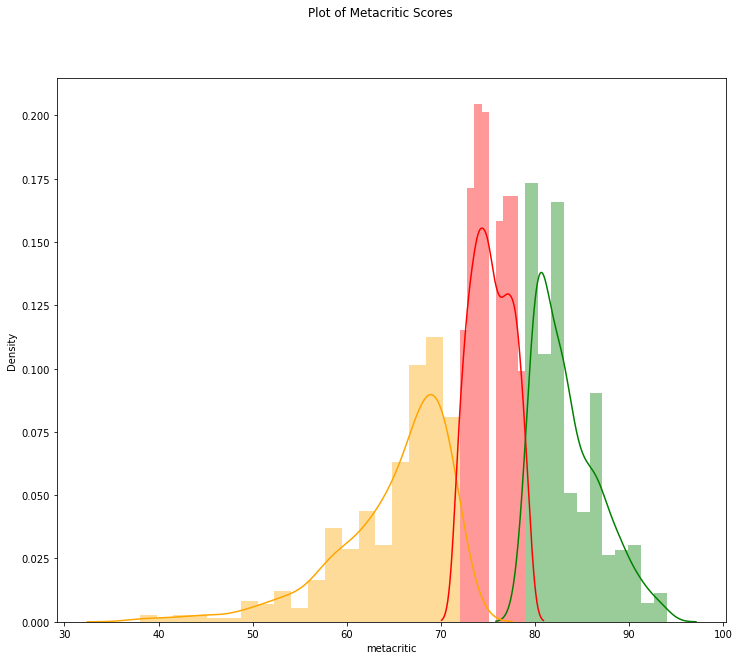

In [ ]:
fig, axs = plt.subplots(1, 1, figsize = [12,10], sharex = True, sharey = True)
fig.suptitle('Plot of Metacritic Scores')
sns.distplot(steam_t['metacritic'], color = 'green')
sns.distplot(steam_b['metacritic'], color = 'orange')
sns.distplot(steam_m['metacritic'], color = 'red')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

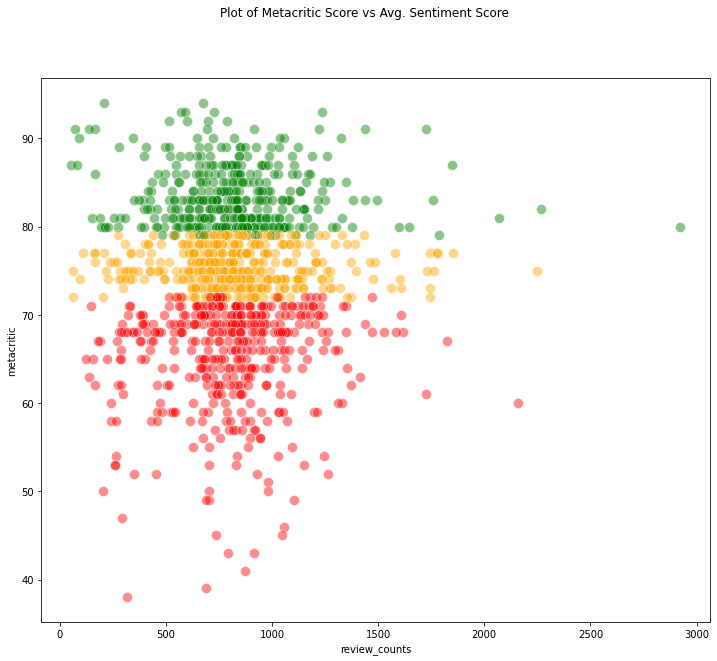

In [ ]:
fig, axs = plt.subplots(1, 1, figsize = [12,10], sharex = True, sharey = True)
fig.suptitle('Plot of Metacritic Score vs Avg. Sentiment Score STEAM')
sns.scatterplot(y = 'metacritic', x = 'review_counts', data =steam_t , s = 100 , alpha = 0.45, color = 'green')
sns.scatterplot(y = 'metacritic', x = 'review_counts', data = steam_m, s = 100, alpha = 0.45, color = 'orange')
sns.scatterplot(y = 'metacritic', x = 'review_counts', data = steam_b, s= 100, alpha = 0.45, color = 'red')
plt.show

In [ ]:
# clean text for NLP
# drop rows where there are no reviews.
for df in steam_team:
    df['reviews'].dropna()
    for x in df['reviews']:
        if x == []:
            df.drop(df['reviews'].loc[x], axis = 0, inplace = True)



In [ ]:
# clean text for processing and model development.


,index,steam_appid,name,metacritic,reviews,review_counts,review_update
0,6346,373420,Divinity: Original Sin - Enhanced Edition,94.0,"[Amazing RPG. Great story, characters and dial...",4881,"Amazing RPG. Great story, characters and dialo..."
1,1186,72850,The Elder Scrolls V: Skyrim,94.0,[It's Skyrim. I don't need to say anything el...,1872,It's Skyrim. I don't need to say anything els...
2,1858,228200,Company of Heroes,93.0,[This is a positive review of this company's g...,949,This is a positive review of this company's ga...
3,8625,435150,Divinity: Original Sin 2 - Definitive Edition,93.0,[As most people know by now... This game is am...,3136,As most people know by now... This game is ama...
4,3361,292030,The Witcher® 3: Wild Hunt,93.0,"[nice game, you need try it, but it is always ...",1060,"nice game, you need try it, but it is always s..."
5,154,4560,Company of Heroes - Legacy Edition,93.0,[I have had tons of fun on this game already a...,3072,I have had tons of fun on this game already an...
6,227,7940,Call of Duty® 4: Modern Warfare®,92.0,"[Best Call of Duty game ever made, Promod was ...",2290,"Best Call of Duty game ever made, Promod was a..."
7,14244,587620,OKAMI HD / 大神 絶景版,92.0,"[This game is quite easy, but don't let this s...",868,"This game is quite easy, but don't let this st..."
8,7060,391540,Undertale,92.0,"[One of the, if not the best game of the 2010s...",931,"One of the, if not the best game of the 2010s...."
9,2030,238210,System Shock 2,92.0,"[when the game is good, I NEED TO RESEARCH, WH...",2546,"when the game is good,I NEED TO RESEARCH, WHER..."
